# 特征工程

- Data PreProcessing（数据预处理）
- Feature Extraction（特征提取）
- Feature Selection（特征选择）
- Feature construction（特征构造）

其中数据预处理包括数据清洗和特征预处理。第三周主要针对数据预处理展开。具体可以参考下图
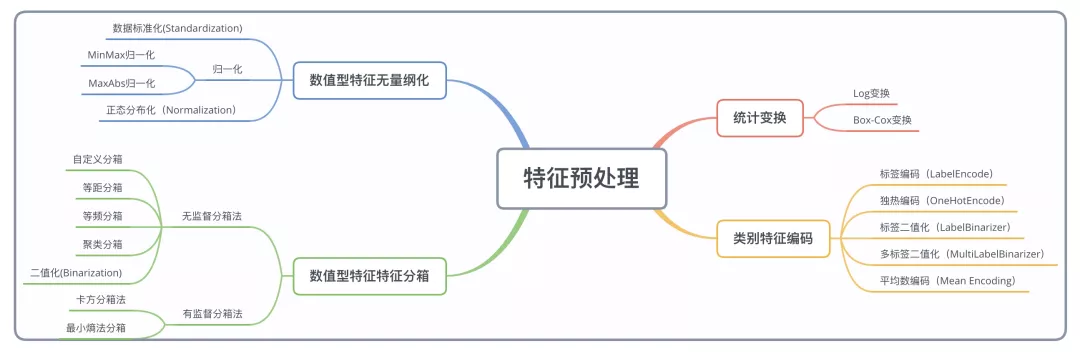

# KDTree实现

In [1]:
import math
import xml.etree.ElementTree as ET
import pprint
import sys


CIRCLE_TAG_NAME = '{http://www.w3.org/2000/svg}circle'
GROUP_TAG_NAME = '{http://www.w3.org/2000/svg}g'


pp = pprint.PrettyPrinter(indent=4)


def circle_to_point(circle):
    return (float(circle.attrib['cx']),
            float(circle.attrib['cy']))


def read_svg_file(svg_file_name):
    return ET.parse(svg_file_name)


def get_all_points(tree):
    return [circle_to_point(circle)
            for circle in tree.iter(CIRCLE_TAG_NAME)]


def get_point_by_id(tree, point_id):
    return [circle_to_point(circle)
            for circle in tree.iter(CIRCLE_TAG_NAME)
            if 'id' in circle.attrib
            if circle.attrib['id'] == point_id]


def get_group_by_id(tree, group_id):
    return [circle
            for group in tree.iter(GROUP_TAG_NAME)
            if 'id' in group.attrib
            if group.attrib['id'] == group_id
            for circle in get_all_points(group)]




def distance_squared(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    dx = x1 - x2
    dy = y1 - y2

    return dx * dx + dy * dy


def closest_point(all_points, new_point):
    best_point = None
    best_distance = None

    for current_point in all_points:
        current_distance = distance_squared(new_point, current_point)

        if best_distance is None or current_distance < best_distance:
            best_distance = current_distance
            best_point = current_point

    return best_point


k = 2


def build_kdtree(points, depth=0):
    n = len(points)

    if n <= 0:
        return None

    axis = depth % k

    sorted_points = sorted(points, key=lambda point: point[axis])

    return {
        'point': sorted_points[n // 2],
        'left': build_kdtree(sorted_points[:n // 2], depth + 1),
        'right': build_kdtree(sorted_points[n // 2 + 1:], depth + 1)
    }


def kdtree_naive_closest_point(root, point, depth=0, best=None):
    if root is None:
        return best

    axis = depth % k

    next_best = None
    next_branch = None

    if best is None or distance_squared(point, best) > distance_squared(point, root['point']):
        next_best = root['point']
    else:
        next_best = best

    if point[axis] < root['point'][axis]:
        next_branch = root['left']
    else:
        next_branch = root['right']

    return kdtree_naive_closest_point(next_branch, point, depth + 1, next_best)


def closer_distance(pivot, p1, p2):
    if p1 is None:
        return p2

    if p2 is None:
        return p1

    d1 = distance_squared(pivot, p1)
    d2 = distance_squared(pivot, p2)

    if d1 < d2:
        return p1
    else:
        return p2


def kdtree_closest_point(root, point, depth=0):
    if root is None:
        return None

    axis = depth % k

    next_branch = None
    opposite_branch = None

    if point[axis] < root['point'][axis]:
        next_branch = root['left']
        opposite_branch = root['right']
    else:
        next_branch = root['right']
        opposite_branch = root['left']

    best = closer_distance(point,
                           kdtree_closest_point(next_branch,
                                                point,
                                                depth + 1),
                           root['point'])

    if distance_squared(point, best) > (point[axis] - root['point'][axis]) ** 2:
        best = closer_distance(point,
                               kdtree_closest_point(opposite_branch,
                                                    point,
                                                    depth + 1),
                               best)

    return best

svg_files = ['./points.svg', './points2.svg', './points3.svg']
for svg_file in svg_files:
    print(svg_file)
    svg_tree = read_svg_file(svg_file)
    [pivot] = get_point_by_id(svg_tree, 'pivot')
    [expected] = get_point_by_id(svg_tree, 'closest')
    points = get_group_by_id(svg_tree, 'points')
    kdtree = build_kdtree(points)

    found = kdtree_closest_point(kdtree, pivot)

    expected_distance = math.sqrt(distance_squared(pivot, expected))
    found_distance = math.sqrt(distance_squared(pivot, found))

    print("  Expected: %s (distance: %f)" % (expected, expected_distance))
    print("  Found:    %s (distance: %f)" % (found, found_distance))

    if found_distance > expected_distance:
        print("  ----- FAILURE! FOUND WORSE DISTANCE! -----")
        sys.exit(1)

./points.svg
  Expected: (803.07129, 323.03201) (distance: 161.883015)
  Found:    (803.07129, 323.03201) (distance: 161.883015)
./points2.svg
  Expected: (140.0, 110.0) (distance: 20.000000)
  Found:    (140.0, 110.0) (distance: 20.000000)
./points3.svg
  Expected: (93.825714, 78.357788) (distance: 14.728257)
  Found:    (93.825714, 78.357788) (distance: 14.728257)


# 参考文献
1. https://github.com/tsoding/kdtree-in-python
2. https://www.youtube.com/watch?v=XqXSGSKc8NU
3. https://github.com/stefankoegl/kdtree